# All PREPARE

## IMPORT Data and libraries

In [1]:
import pandas as pd 
import numpy as np
from pathlib import Path
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
docs_folder = Path(Path.cwd()/'docs')
data_upload = Path(docs_folder/ 'Выгрузка.xlsx')
data_plan = Path(docs_folder/ 'План.xlsx')
# df_upload_raw = pd.read_excel(data_upload)

In [3]:
from normalize_data import (
    UploadData,
    PlanFactData,

    PlanFactTools
)

In [13]:
upload_data = UploadData(_path_excel_data=data_upload)
df_upload_raw = upload_data.normalize_upload_df()

plan_fact = PlanFactData(_path_excel_data=data_plan)
df_audience,df_tvr =  plan_fact.split_plan_fact_df()

df_audience = PlanFactTools(df_audience) \
        .mapping_to_numeric_date() \
        .melted_data() \
        .df_processed

df_tvr= PlanFactTools(df_tvr) \
        .mapping_to_numeric_date() \
        .melted_data() \
        .df_processed

# Аналитика

## Tasks 1
 - [x] Задача: понять, выполняется ли в каждой кампании плановый объём TRP
    - general_rating рейтинг = 6
 - [x] Задача: по всем кампаниям
    - rating_each_company
    - rating_analog
    - [x] каналов дистрибъюции 1 == Сетевой : 3966
      - df_upload_raw.distribution_ch.value_counts()

In [7]:
# Группировка 'telecomp' & 'month'
df_group_upload= (
    df_upload_raw[['telecomp','TVR','month']]
    .groupby(['telecomp','month'])
    .agg(sum).reset_index()
    )

In [8]:
def calculate_rating(deviation):
    if deviation > 5:
        rating = 10
    elif deviation == 0:
        rating = 8
    else:
        rating = 1 + (deviation / 5) * 7 
    return round(rating,2)

In [14]:
def make_compare_fact_plan_df(
    group_by_value,melted_df
    ):
    df_compare=(
        pd.merge(melted_df,df_group_upload,on=['telecomp','month'])
        .groupby(group_by_value).agg(
            plan=('plan','sum'),
            fact=('TVR','sum')).reset_index()
        )
    df_compare[['fact','plan']] = df_compare[['fact','plan']].apply(pd.to_numeric)
    df_compare['TVR_deviation'] = (df_compare['fact'] - df_compare['plan']) / df_compare['plan'] * 100


    return df_compare


,company,rating_
0,1,10.00
1,3,5.70
2,5,10.00
3,7,-5.14
4,9,5.39
5,11,-2.91


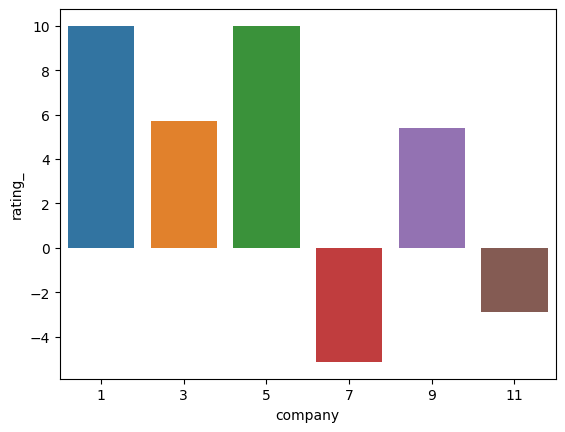

In [27]:

df_compare = make_compare_fact_plan_df(group_by_value=['month'],melted_df=df_tvr)

df_compare['rating_'] = df_compare['TVR_deviation'].apply(calculate_rating)

df_compare= df_compare.rename(columns={'month':"company"})
group_by_company = df_compare[['company','rating_']]
sns.barplot(data=group_by_company,x='company',y='rating_')
group_by_company

<Axes: xlabel='company', ylabel='rating_'>

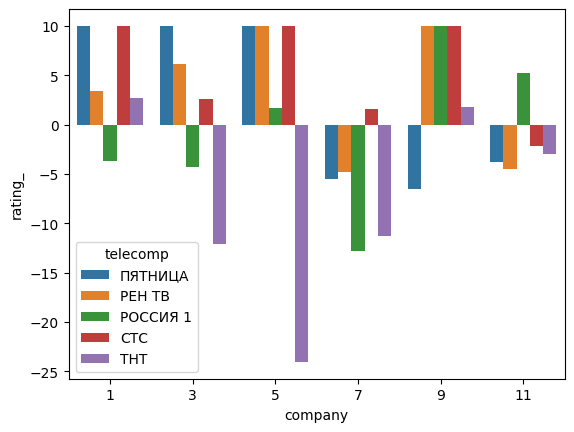

In [29]:

by_company= (
    make_compare_fact_plan_df(
        group_by_value=["month",'telecomp',],
        melted_df=df_tvr) 
    [['month',"TVR_deviation",'telecomp','fact','plan']])
    
by_company['rating_'] = by_company['TVR_deviation'].apply(calculate_rating)

by_company = by_company.rename(columns={"month":"company"})
by_company.sort_values(by='company',ascending=True)

sns.barplot(data=by_company,x='company',y='rating_',hue="telecomp")

<Axes: xlabel='company', ylabel='TVR_deviation'>

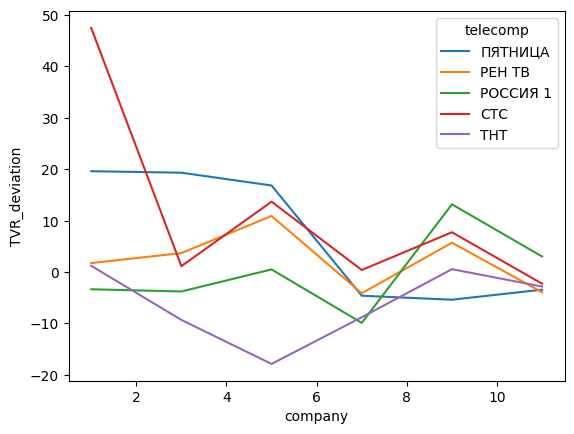

In [19]:
sns.lineplot(data=by_company.sort_values(by='company'),x='company',y='TVR_deviation',hue='telecomp')

<Axes: xlabel='telecomp', ylabel='value'>

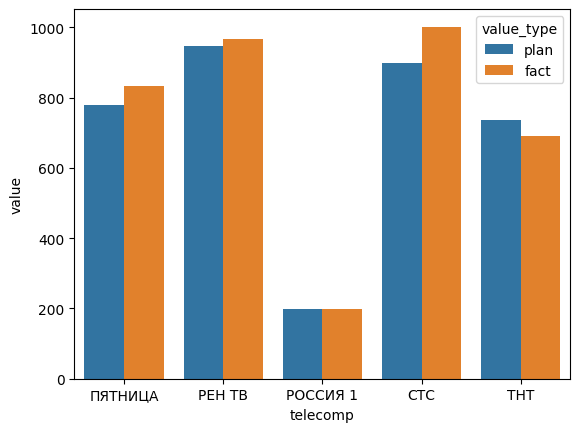

In [20]:

df_audience= by_company.groupby(
    'telecomp',as_index=False).agg(
        plan=("plan",'sum'),
        fact=("fact",'sum'))
df_audience_melted = df_audience.melt(id_vars='telecomp', value_vars=['plan', 'fact'], var_name='value_type', value_name='value')

df_audience_melted
sns.barplot(
    data=df_audience_melted,
    y="value",
    x="telecomp",
    hue='value_type'
    )

# Рейтинг компаний друг относительно друга
## 1. quantile

In [42]:
# by every month quanilte
df = df_compare
q10 = df['TVR_deviation'].quantile(0.1)
q90 = df['TVR_deviation'].quantile(0.9)

df['rating_by_distribute'] = np.where(df['TVR_deviation'] < q10, 0, np.where(df['TVR_deviation'] > q90, 10, ((df['TVR_deviation'] - q10) / (q90 - q10)) * 10))

# Rounding ratings to nearest integer
df['rating_by_distribute'] = df['rating_by_distribute'].round().astype(int)
rating_analog = df[['company',"TVR_deviation","rating_",'rating_by_distribute']]
rating_analog


,company,TVR_deviation,rating_,rating_by_distribute
0,1,16.818429,10.00,10
1,3,3.354543,5.70,5
2,5,6.368616,10.00,7
3,7,-4.382761,-5.14,0
4,9,3.137887,5.39,4
5,11,-2.792764,-2.91,1


# Plotly

In [ ]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots